In [1]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import seaborn as sns

from statannotations.Annotator import Annotator


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()


In [5]:
from collections import defaultdict

data_dir = (Path().cwd().parents[0] / 'data').absolute()

# Get image dataframe 
df_imgs_path = data_dir / 'OCT Mouse' / 'Whole' / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_imgs_path)


# Initial statistics

In [6]:
PPI_save_path =  data_dir / 'OCT Mouse' / 'Whole' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

In [7]:
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']


In [8]:
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)

In [9]:
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [10]:
# Filter out by maximum number of counts per cell
min_count = 5
max_count = 40

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()

,Count_cell,Count_nuclei,Count_cyto
count,44087.000000,44087.000000,44087.000000
mean,23.483000,9.650509,13.832490
std,17.092927,10.356716,10.981994
min,6.000000,0.000000,-112.000000
25%,11.000000,3.000000,6.000000
50%,18.000000,7.000000,11.000000
75%,31.000000,13.000000,19.000000
max,176.000000,246.000000,114.000000


In [11]:
df_all = df_all[df_all['Count_cyto']>=0]

## Plots

In [12]:
from statsmodels.stats.weightstats import ztest as ztest


In [13]:
df_all.PPI.unique()

array(['CylinE & CDK2', 'Mcl-1 & BAK', 'P-ERK & c-MYC', 'TEAD1 & YAP1',
       'p-AKT & mTOR'], dtype=object)

In [14]:
a = df_all[(df_all.PPI ==  'Mcl-1 & BAK')&(df_all.Condition == '1W')]['Count_cell']
b = df_all[(df_all.PPI ==  'Mcl-1 & BAK')&(df_all.Condition == '1M')]['Count_cell']

In [15]:
ztest(a[::10],b[::10], alternative='two-sided')

(7.037507156822071, 1.9570948726446566e-12)

In [16]:
def plot(plotting, figsize=(7,4)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]
    p_values = [ztest(
                plotting['data'][(plotting['data'][plotting['x']] == e) & (plotting['data'][plotting['hue']] == c1)][plotting['y']][::20],
                plotting['data'][(plotting['data'][plotting['x']] == e) & (plotting['data'][plotting['hue']] == c2)][plotting['y']][::20]                                                      
                )[1]
                for e in plotting['data'][plotting['x']].unique()]
    print(pairs, p_values)
    with sns.plotting_context('talk', font_scale=1):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting,whis=[5,95], showfliers=False,ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        # annot.configure(test='t-test_ind',comparisons_correction="Bonferroni", text_format='star', loc='outside', verbose=2
        #                 )
        annot.configure(test=None, comparisons_correction="Bonferroni", text_format='star', loc='outside', verbose=2
                        )
        _, p_values
        annot.set_pvalues(p_values)
        # result = annot.apply_test().annotate()
        result = annot.annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [17]:
# df_all = df_all[~df_all['PPI'].isin(['Cyclin D1 & CDK2'])]

[(('CylinE & CDK2', '1M'), ('CylinE & CDK2', '1W')), (('Mcl-1 & BAK', '1M'), ('Mcl-1 & BAK', '1W')), (('P-ERK & c-MYC', '1M'), ('P-ERK & c-MYC', '1W')), (('TEAD1 & YAP1', '1M'), ('TEAD1 & YAP1', '1W')), (('p-AKT & mTOR', '1M'), ('p-AKT & mTOR', '1W'))] [5.258309505331986e-06, 4.6140054932193725e-10, 1.2672207446749833e-28, 0.008405174060263764, 5.128631008866148e-45]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 & BAK_1M vs. Mcl-1 & BAK_1W: Custom statistical test with Bonferroni correction, P_val:2.307e-09
CylinE & CDK2_1M vs. CylinE & CDK2_1W: Custom statistical test with Bonferroni correction, P_val:2.629e-05
P-ERK & c-MYC_1M vs. P-ERK & c-MYC_1W: Custom statistical test with Bonferroni correction, P_val:6.336e-28
TEAD1 & YAP1_1M vs. TEAD1 & YAP1_1W: Custom statistical test with Bonferroni correction, P_val:4.203e-02
p-AKT & mTOR_1M vs. p-AKT &

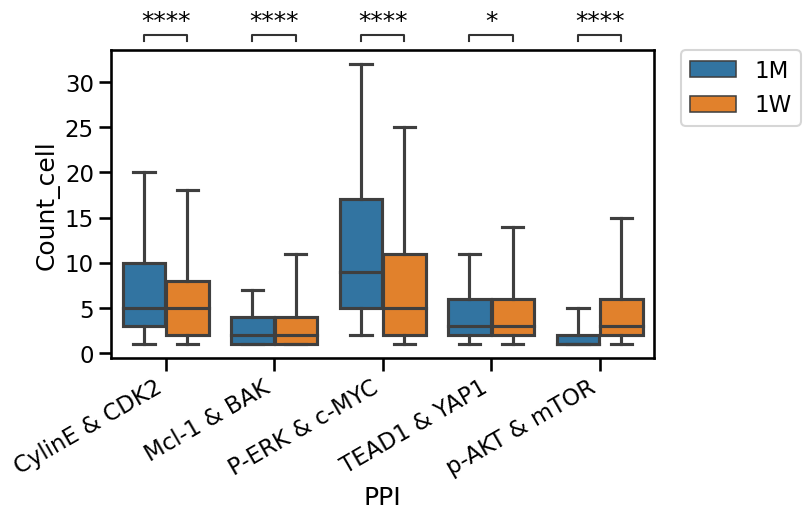

In [18]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

[(('CylinE & CDK2', '1M'), ('CylinE & CDK2', '1W')), (('Mcl-1 & BAK', '1M'), ('Mcl-1 & BAK', '1W')), (('P-ERK & c-MYC', '1M'), ('P-ERK & c-MYC', '1W')), (('TEAD1 & YAP1', '1M'), ('TEAD1 & YAP1', '1W')), (('p-AKT & mTOR', '1M'), ('p-AKT & mTOR', '1W'))] [1.7246599071536016e-07, 0.06124436250814268, 3.599876043090724e-25, 0.11049616698658882, 8.722857748756907e-11]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 & BAK_1M vs. Mcl-1 & BAK_1W: Custom statistical test with Bonferroni correction, P_val:3.062e-01
CylinE & CDK2_1M vs. CylinE & CDK2_1W: Custom statistical test with Bonferroni correction, P_val:8.623e-07
P-ERK & c-MYC_1M vs. P-ERK & c-MYC_1W: Custom statistical test with Bonferroni correction, P_val:1.800e-24
TEAD1 & YAP1_1M vs. TEAD1 & YAP1_1W: Custom statistical test with Bonferroni correction, P_val:5.525e-01
p-AKT & mTOR_1M vs. p-AKT & mTO

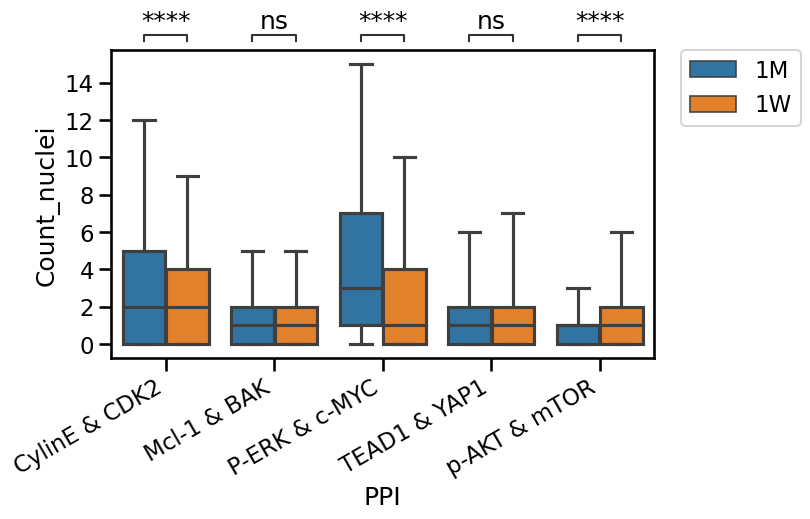

In [19]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition"
}

plot(plotting)

[(('CylinE & CDK2', '1M'), ('CylinE & CDK2', '1W')), (('Mcl-1 & BAK', '1M'), ('Mcl-1 & BAK', '1W')), (('P-ERK & c-MYC', '1M'), ('P-ERK & c-MYC', '1W')), (('TEAD1 & YAP1', '1M'), ('TEAD1 & YAP1', '1W')), (('p-AKT & mTOR', '1M'), ('p-AKT & mTOR', '1W'))] [0.08787355351214028, 4.491023406303231e-12, 4.3462185026783507e-17, 0.017822172931206404, 7.769080407565746e-49]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 & BAK_1M vs. Mcl-1 & BAK_1W: Custom statistical test with Bonferroni correction, P_val:2.246e-11
CylinE & CDK2_1M vs. CylinE & CDK2_1W: Custom statistical test with Bonferroni correction, P_val:4.394e-01
P-ERK & c-MYC_1M vs. P-ERK & c-MYC_1W: Custom statistical test with Bonferroni correction, P_val:2.173e-16
TEAD1 & YAP1_1M vs. TEAD1 & YAP1_1W: Custom statistical test with Bonferroni correction, P_val:8.911e-02
p-AKT & mTOR_1M vs. p-AKT & mT

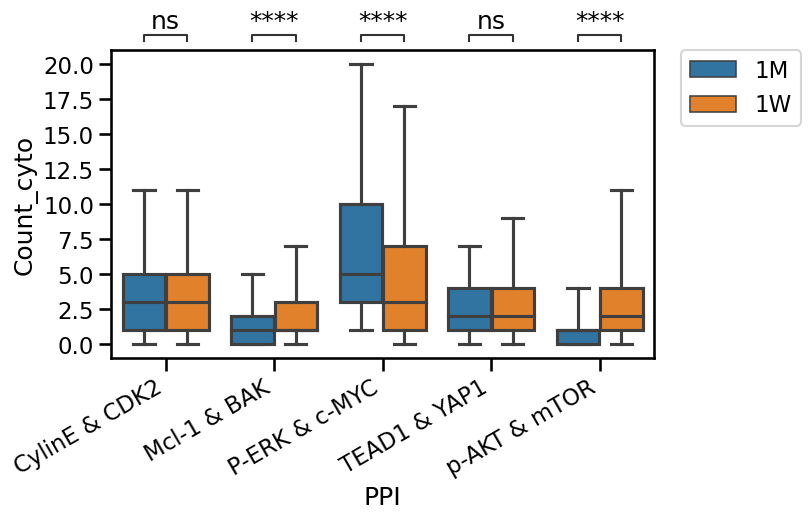

In [20]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition"
}

plot(plotting)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 & BAK_Count_nuclei vs. Mcl-1 & BAK_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:4.357e-303 U_stat=4.733e+07
CylinE & CDK2_Count_nuclei vs. CylinE & CDK2_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:8.422e-237 U_stat=1.116e+08
P-ERK & c-MYC_Count_nuclei vs. P-ERK & c-MYC_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=8.302e+07
TEAD1 & YAP1_Count_nuclei vs. TEAD1 & YAP1_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=8.655e+07
p-AKT & mTOR_Count_nuclei vs. p-AKT & mTOR_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=6.598e+07
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-

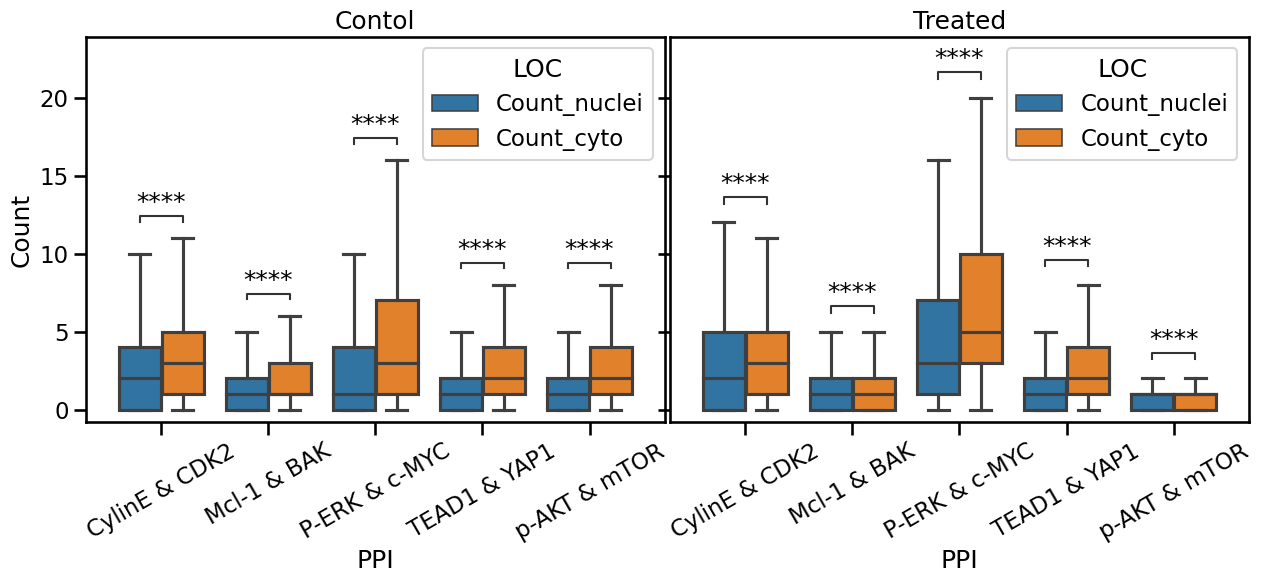

In [21]:
# Boxplot per loc
df_melt = df_all.melt(id_vars=['Condition', 'PPI'], 
                      value_vars=['Count_nuclei', 'Count_cyto'],
                     var_name='LOC',
                     value_name='Count')


df_melt['Count'] = df_melt['Count'].clip(0, upper=None)

with sns.plotting_context('talk', font_scale=1.):
    fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
    
    # Left figure
    df_subset = df_melt[df_melt.Condition == '1W']
    
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[0])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[0].tick_params(axis='x', rotation=30)
    
    # Right figure

    df_subset = df_melt[df_melt.Condition == '1M']
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[1])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[1].tick_params(axis='x', rotation=30)
    
    axs[0].set_title('Contol')
    axs[1].set_title('Treated')
    axs[1].set_ylabel('')
    fig.subplots_adjust(wspace=0.01)

# Extract cell mean expression level

In [22]:
from skimage import measure

In [23]:
mask_filt_dir = data_dir / 'OCT mouse' / 'Whole' / 'imgs' / 'masks_filtered'
PPI_save_path =  data_dir / 'OCT mouse'/ 'Whole' / 'PPI'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [24]:
# exp_data_dir = data_dir / 'OCT mouse'/ 'Whole' / 'expression' 
# exp_data_dir.mkdir(exist_ok=True)

# for row in df_imgs.itertuples():
#     name = '_'.join(row[1:3])
#     imgs_path = row.Path
    
#     # Read masks
#     mask_cyto_path = masks_path[name]['cell']
#     mask_nuclei_path = masks_path[name]['nuclei']
#     df_path =  masks_path[name]['df']
    
#     mask_cyto = skimage.io.imread(mask_cyto_path)
    
#     # Read imgs
#     with h5py.File(imgs_path, "r") as f:
#         markers = f['imgs'].attrs['Marker']
#         index = np.where(markers == 'Pan-cytokeratin')[0][0]
#         img_pan = f['imgs'][index, :]
        
#     # Get mean expression per cell
#     props = measure.regionprops_table(mask_cyto, img_pan, properties=('label', 'mean_intensity'))
#     df_exp = pd.DataFrame(props)
#     df_exp.columns = ['Cell Id', 'Expression']
    
#     df_exp.to_csv(exp_data_dir / f'{name}.csv')
    

## Filter low pan cytokeratin expression cell

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [26]:
exp_data_dir = data_dir / 'OCT mouse'/ 'Whole' / 'expression' 

dfs = []
for path in os.listdir(exp_data_dir):
    if 'csv' in path:
        df = pd.read_csv(exp_data_dir / path)
        df['Expression'] = scaler.fit_transform(df[['Expression']])
        name_list = os.path.splitext(path)[0].split('_')
        df['Condition'] = name_list[0]
        df['FOV'] = name_list[1]
        dfs.append(df)

df_exp = pd.concat(dfs)


In [27]:
df_merged = df_all.merge(df_exp, how='left', left_on=['Condition', 'FOV', 'Id'], right_on=['Condition', 'FOV', 'Cell Id'])

In [28]:
df_merged =  df_merged[df_merged['Expression'] > 0.1]

[(('CylinE & CDK2', '1M'), ('CylinE & CDK2', '1W')), (('Mcl-1 & BAK', '1M'), ('Mcl-1 & BAK', '1W')), (('P-ERK & c-MYC', '1M'), ('P-ERK & c-MYC', '1W')), (('TEAD1 & YAP1', '1M'), ('TEAD1 & YAP1', '1W')), (('p-AKT & mTOR', '1M'), ('p-AKT & mTOR', '1W'))] [0.004832501847955462, 0.0009217497088506595, 1.2905657385718818e-20, 0.31038376623519737, 2.2241505360203896e-05]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 & BAK_1M vs. Mcl-1 & BAK_1W: Custom statistical test with Bonferroni correction, P_val:4.609e-03
CylinE & CDK2_1M vs. CylinE & CDK2_1W: Custom statistical test with Bonferroni correction, P_val:2.416e-02
P-ERK & c-MYC_1M vs. P-ERK & c-MYC_1W: Custom statistical test with Bonferroni correction, P_val:6.453e-20
TEAD1 & YAP1_1M vs. TEAD1 & YAP1_1W: Custom statistical test with Bonferroni correction, P_val:1.000e+00
p-AKT & mTOR_1M vs. p-AKT & m

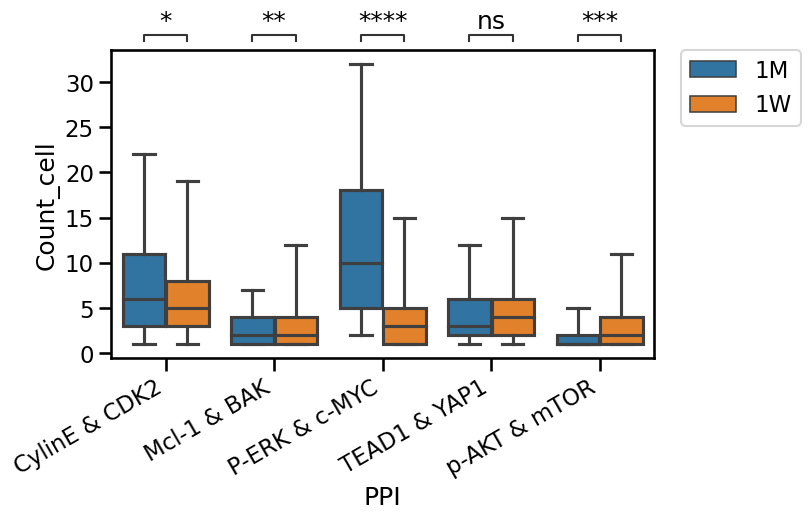

In [29]:
# Boxplot per cell
plotting = {
    "data": df_merged,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

[(('CylinE & CDK2', '1M'), ('CylinE & CDK2', '1W')), (('Mcl-1 & BAK', '1M'), ('Mcl-1 & BAK', '1W')), (('P-ERK & c-MYC', '1M'), ('P-ERK & c-MYC', '1W')), (('TEAD1 & YAP1', '1M'), ('TEAD1 & YAP1', '1W')), (('p-AKT & mTOR', '1M'), ('p-AKT & mTOR', '1W'))] [0.3851174725419704, 0.14746485678255974, 1.2582439802190374e-09, 0.785392103563812, 0.07246700422402932]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 & BAK_1M vs. Mcl-1 & BAK_1W: Custom statistical test with Bonferroni correction, P_val:7.373e-01
CylinE & CDK2_1M vs. CylinE & CDK2_1W: Custom statistical test with Bonferroni correction, P_val:1.000e+00
P-ERK & c-MYC_1M vs. P-ERK & c-MYC_1W: Custom statistical test with Bonferroni correction, P_val:6.291e-09
TEAD1 & YAP1_1M vs. TEAD1 & YAP1_1W: Custom statistical test with Bonferroni correction, P_val:1.000e+00
p-AKT & mTOR_1M vs. p-AKT & mTOR_1W: C

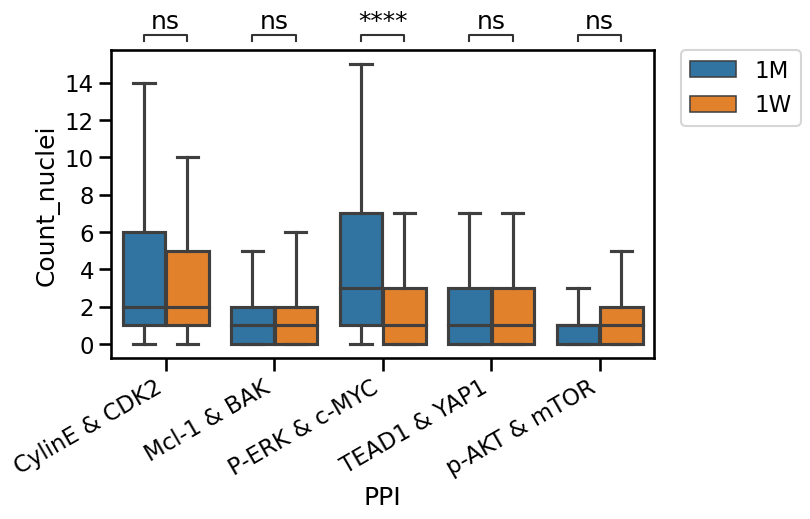

In [30]:
# Boxplot per cell
plotting = {
    "data":  df_merged,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition"
}

plot(plotting)

[(('CylinE & CDK2', '1M'), ('CylinE & CDK2', '1W')), (('Mcl-1 & BAK', '1M'), ('Mcl-1 & BAK', '1W')), (('P-ERK & c-MYC', '1M'), ('P-ERK & c-MYC', '1W')), (('TEAD1 & YAP1', '1M'), ('TEAD1 & YAP1', '1W')), (('p-AKT & mTOR', '1M'), ('p-AKT & mTOR', '1W'))] [9.44936508098196e-05, 0.0019371884179309427, 1.4969112619216024e-16, 0.22923019552725388, 1.1387150458889113e-05]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 & BAK_1M vs. Mcl-1 & BAK_1W: Custom statistical test with Bonferroni correction, P_val:9.686e-03
CylinE & CDK2_1M vs. CylinE & CDK2_1W: Custom statistical test with Bonferroni correction, P_val:4.725e-04
P-ERK & c-MYC_1M vs. P-ERK & c-MYC_1W: Custom statistical test with Bonferroni correction, P_val:7.485e-16
TEAD1 & YAP1_1M vs. TEAD1 & YAP1_1W: Custom statistical test with Bonferroni correction, P_val:1.000e+00
p-AKT & mTOR_1M vs. p-AKT & m

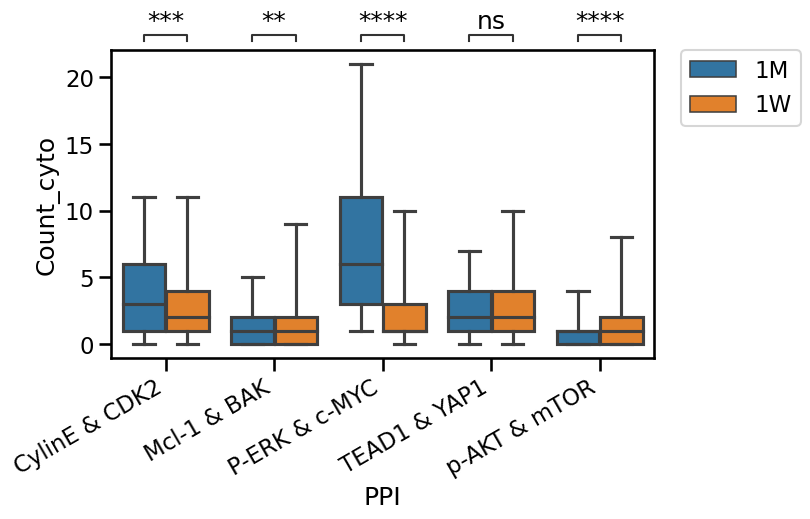

In [31]:
# Boxplot per cell
plotting = {
    "data":  df_merged,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition"
}

plot(plotting)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 & BAK_Count_nuclei vs. Mcl-1 & BAK_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:2.084e-05 U_stat=1.514e+06
CylinE & CDK2_Count_nuclei vs. CylinE & CDK2_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.717e-03 U_stat=3.409e+06
P-ERK & c-MYC_Count_nuclei vs. P-ERK & c-MYC_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:9.465e-09 U_stat=1.872e+06
TEAD1 & YAP1_Count_nuclei vs. TEAD1 & YAP1_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:3.218e-43 U_stat=2.107e+06
p-AKT & mTOR_Count_nuclei vs. p-AKT & mTOR_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:7.498e-11 U_stat=1.428e+06
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 

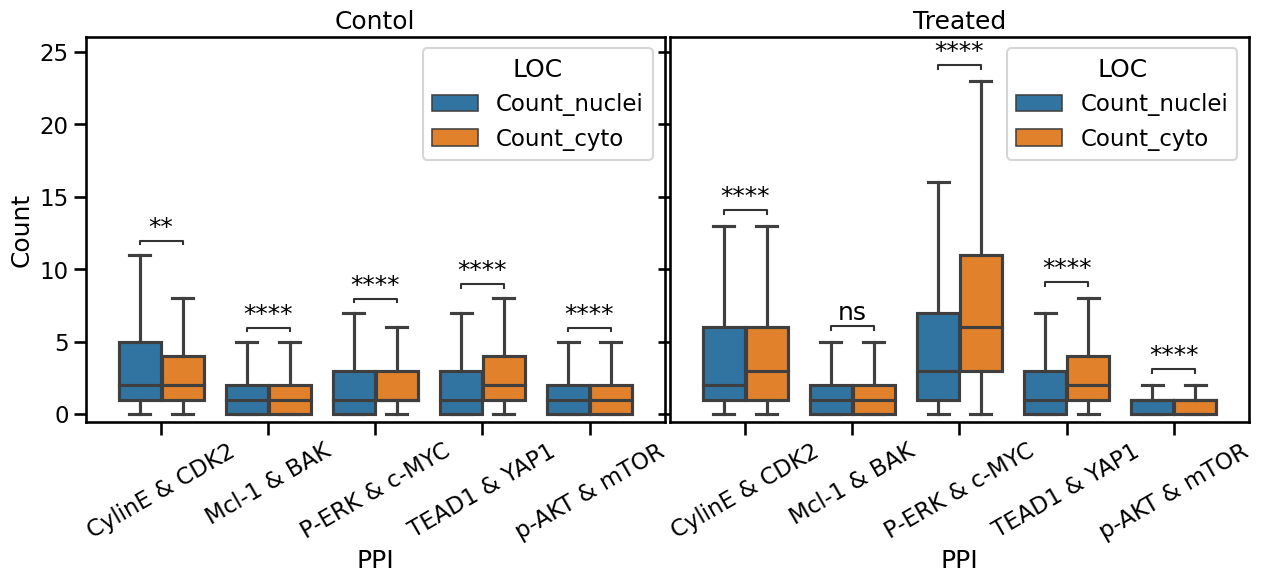

In [32]:
# Boxplot per loc
df_melt =  df_merged.melt(id_vars=['Condition', 'PPI'], 
                      value_vars=['Count_nuclei', 'Count_cyto'],
                     var_name='LOC',
                     value_name='Count')


df_melt['Count'] = df_melt['Count'].clip(0, upper=None)

with sns.plotting_context('talk', font_scale=1.):
    fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
    
    # Left figure
    df_subset = df_melt[df_melt.Condition == '1W']
    
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[0])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[0].tick_params(axis='x', rotation=30)
    
    # Right figure

    df_subset = df_melt[df_melt.Condition == '1M']
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[1])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[1].tick_params(axis='x', rotation=30)
    
    axs[0].set_title('Contol')
    axs[1].set_title('Treated')
    axs[1].set_ylabel('')
    fig.subplots_adjust(wspace=0.01)